In [1]:
# global import

import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split


5.1 Data Preparation

In [65]:
filenames = glob.glob("lab5_files/face_mini/*/*.jpg")
len(filenames)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
all_images = []

for idx, img_path in enumerate(filenames):
    img = image.load_img(img_path, target_size=(100, 100), interpolation="nearest")
    # convert the image to an array
    img = image.img_to_array(img)
    # Normalized color imageimg
    img = img / 255
    all_images.append(img)
    # if idx == 50:
    #   break

all_images = np.array(all_images)
all_images.shape

(3203, 100, 100, 3)

In [66]:
# split data into train and validation data
train_x, val_x = train_test_split(all_images, test_size=0.3, random_state=32)
print(train_x.shape)
print(val_x.shape)

(2242, 100, 100, 3)
(961, 100, 100, 3)


5.2 ADD NOISE

In [69]:
noise_factor = 0.8 # scalar between 0 -1 ลองอย่ํางน้อย 2 ค่ํา
Nmean = 0
Nstd = 1

# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape) )
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


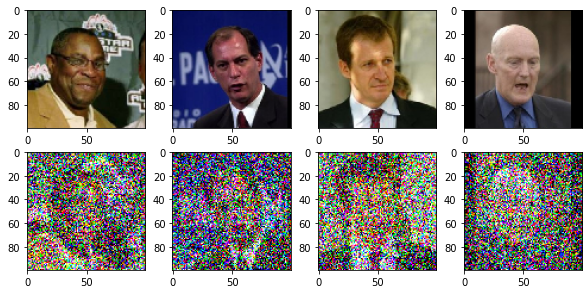

In [70]:
fig = plt.figure(figsize=(10, 10))
size = 4
for i in range(0, size):
  fig.add_subplot(size, size, i+1)
  plt.imshow(train_x[i], cmap="jet")
  fig.add_subplot(size, size, size+i+1)
  plt.imshow(x_train_noisy[i], cmap="jet")
  

In [71]:
# กำหนด Encoder Architecture
Input_img = Input(shape=(100, 100, 3))
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# กำหนด Decoder Architecture
# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

# ก ําหนด optimizer setting
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse') #-> loss ใช้ Mean Square Error
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 100, 100, 256)     7168      
                                                                 
 conv2d_29 (Conv2D)          (None, 100, 100, 128)     295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_30 (Conv2D)          (None, 50, 50, 64)        73792     
                                                                 
 conv2d_31 (Conv2D)          (None, 50, 50, 64)        36928     
                                                           

In [72]:
# ก ําหนด Training parameter
# epoch ทดลองอย่ํางน้อย 2 ค่ํา [ 2, 3, 4 ]
# batch_size ทดลองอย่ํางน้อย 1 ค่ํา [8, 16, 32]

epochs = 4
batch_size = 32
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=2)

# เริ่มการ Training
history = autoencoder.fit(x=x_train_noisy, 
                          y=train_x, 
                          batch_size=batch_size,
                          epochs=epochs, 
                          shuffle=True, 
                          validation_data=(x_val_noisy, val_x), 
                          callbacks=[early_stopper])

Epoch 1/4
71/71 [==============================] - 580s 8s/step - loss: 0.0378 - val_loss: 0.0161
Epoch 2/4
71/71 [==============================] - 600s 8s/step - loss: 0.0130 - val_loss: 0.0123
Epoch 3/4
71/71 [==============================] - 625s 9s/step - loss: 0.0110 - val_loss: 0.0113
Epoch 4/4
71/71 [==============================] - 670s 9s/step - loss: 0.0104 - val_loss: 0.0110


In [73]:
# ทดสอบ autoencoder model ด้วย validation
predictions = autoencoder.predict(x_val_noisy)
predictions.shape

(961, 100, 100, 3)

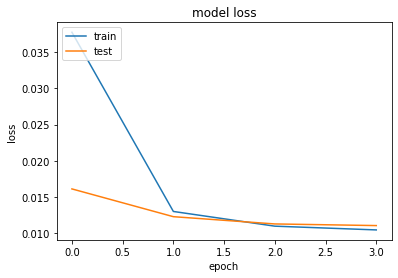

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


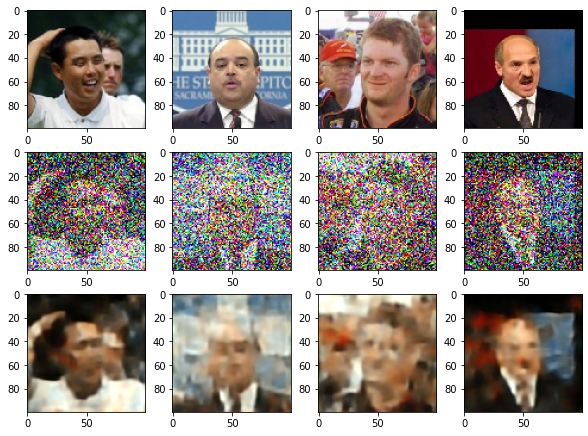

In [75]:
fig = plt.figure(figsize=(10, 10))
size = 4
for i in range(0, size):
  fig.add_subplot(size, size, i+1)
  plt.imshow(val_x[i])
  fig.add_subplot(size, size, size+i+1)
  plt.imshow(x_val_noisy[i])
  fig.add_subplot(size, size, size+size+i+1)
  plt.imshow(predictions[i])
  